# Sparkify Project: Building Customer Churn Predictive Model Using SPARK

In this notebook, we build a model for Sparkify, an imaginary music streaming application. We have access to the dataset and we will using some of the features to predict churn. We use Spark for both to process the data and build the model.

**Load all libraries required**

In [1]:
# import libraries
import os

from pyspark.sql import SparkSession;
from pyspark.sql.functions import isnan,count,when,col, concat, desc, explode, lit, min, max, split, udf, isnull;
from pyspark.sql.types import IntegerType;

from pyspark.ml.feature import RegexTokenizer, CountVectorizer,IDF, StringIndexer,VectorAssembler, Normalizer, StandardScaler;
from pyspark.ml import Pipeline;
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier;
from pyspark.ml.evaluation import MulticlassClassificationEvaluator;


import re;
import datetime;
import matplotlib.pyplot as plt;
import pandas as pd;
import seaborn as sns;
import numpy as np;
from itertools import cycle, islice;

**created a Spark session**

In [2]:
# created a Spark session in local with App Name as Sparkify
spark = SparkSession\
                    .builder\
                    .master('local')\
                    .appName("Sparkify")\
                    .getOrCreate();

# Load and Clean Dataset
For this project we have got mini-dataset file ie. `mini_sparkify_event_data.json`. we will Load and clean the dataset, and will check for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
#load data "mini_sparkify_event_data.json"
df = spark.read.json('mini_sparkify_event_data.json');

#see top records in dataset
print(df.take(5));

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'), Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'), Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='Ba

In [4]:
#lets look at shema of data :
df.printSchema();

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
#checking for total records ,total number of columns and  colum names
print("Number of  Rows:",df.count());
print("Number of  columns:",len(df.columns));
print("columns Present in data set:", df.columns);

Number of  Rows: 286500
Number of  columns: 18
columns Present in data set: ['artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName', 'length', 'level', 'location', 'method', 'page', 'registration', 'sessionId', 'song', 'status', 'ts', 'userAgent', 'userId']


In [6]:
#lets describe the data and understand all the columns 
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
artist,228108,551.0852017937219,1217.7693079161374,!!!,ÃÂlafur Arnalds
auth,286500,None,None,Cancelled,Logged Out
firstName,278154,None,None,Adelaida,Zyonna
gender,278154,None,None,F,M
itemInSession,286500,114.41421291448516,129.76726201140994,0,1321
lastName,278154,None,None,Adams,Wright
length,228108,249.1171819778458,99.23517921058361,0.78322,3024.66567
level,286500,None,None,free,paid
location,278154,None,None,"Albany, OR","Winston-Salem, NC"


In [7]:
#check Any NA values in Data and exist drop them as suggested in notebook
df = df.dropna(how = "any", subset = ["userId", "sessionId"]);

**We can see around 846 rows are missing(" ") in Userids lets filter out them as cleaning process**

In [8]:
#check Any Invalid data ex:-> records withouth userids or session ids
print("Number of Rows",df.count());
print("Missing userId's:",df[df.userId==''].count());
print("Missing userId's:",df[df.sessionId==''].count());

Number of Rows 286500
Missing userId's: 8346
Missing userId's: 0


**Note:** Just for data exploration if these new features derived from existing ts  
if intrested you can explore more with these columns which you can use in model building to check if these can improve model perfomance!!

In [9]:
#lets drop missing Userids from data
df = df.filter(df.userId!="");
print("Number of Rows",df.count());


#Just for data exploration and can be used if intrested to improve Model performance
#derive proper hour,weekday,day,time from epoch data;
#hour
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
df = df.withColumn("hour", get_hour(df.ts))

#weekday
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%w"))
df = df.withColumn("weekday", get_weekday(df.ts))

#day
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
df = df.withColumn("day", get_day(df.ts))

#time
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df = df.withColumn("time", get_time(df.ts))

print("Columns Name in dataset:")
df.columns


Number of Rows 278154
Columns Name in dataset:


['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId',
 'hour',
 'weekday',
 'day',
 'time']

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [10]:
#Lets look into Page Feature which has "Cancellation Confirmation" variable 
#from which we can derive our Target Variable ie. churn or not?

#list all distinct events rom page columns
df.select("page").distinct().show();

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [11]:
# lets Create a temp view,so that we can use sparkSQL for quick easy analysis.
df.createOrReplaceTempView('data');

#find total number of uniq user by page(Events);
spark.sql("select page,count(distinct userId) as Count_of_Users from  data  group by page").show();

#find uniq user who are going to Churn ;
spark.sql("select page,count(distinct userId) as Count_of_Users from  data where page='Cancellation Confirmation' group by page").show();

+--------------------+--------------+
|                page|Count_of_Users|
+--------------------+--------------+
|              Cancel|            52|
|    Submit Downgrade|            49|
|         Thumbs Down|           203|
|                Home|           223|
|           Downgrade|           154|
|         Roll Advert|           207|
|              Logout|           213|
|       Save Settings|           132|
|Cancellation Conf...|            52|
|               About|           155|
|            Settings|           195|
|     Add to Playlist|           215|
|          Add Friend|           206|
|            NextSong|           225|
|           Thumbs Up|           220|
|                Help|           192|
|             Upgrade|           168|
|               Error|           117|
|      Submit Upgrade|           131|
+--------------------+--------------+

+--------------------+--------------+
|                page|Count_of_Users|
+--------------------+--------------+
|Cancellati

** Preprocess data to get our target Variable churn**

In [12]:
# Create a dataset with all user ID's and a label which specifies whether that individual churned or not

# First a dataset with users who churned
churn = spark.sql('SELECT DISTINCT userId, 1 as churn FROM data WHERE Page = "Cancellation Confirmation"')

# Then the users who are not
no_churn = spark.sql('SELECT DISTINCT userId, 0 as churn FROM data WHERE userId NOT IN (SELECT DISTINCT userId FROM data WHERE Page = "Cancellation Confirmation")')

# Create a dataframe from the union of the two dataframe's.
user_with_churn_column = churn.union(no_churn)

#lets create table which has userid labeled with churn and not churn flag
user_with_churn_column.createOrReplaceTempView('chur_or_no_churn');

#join with original dataset
df_with_churn_column=spark.sql("select a.*,b.churn from data AS a INNER JOIN chur_or_no_churn AS b on (a.userId=b.userId)")

#create temp table which has Target/class 
df_with_churn_column.createOrReplaceTempView('df_table');

#print("class distribution by user id")
spark.sql("select churn,count(distinct(userId)) from df_table group by churn").show();


# lets see how many unique users are present in this dataset and its matching with our class distrbution.
spark.sql('SELECT COUNT(DISTINCT userId) AS count_Uniq_users FROM data').show()


+-----+----------------------+
|churn|count(DISTINCT userId)|
+-----+----------------------+
|    1|                    52|
|    0|                   173|
+-----+----------------------+

+----------------+
|count_Uniq_users|
+----------------+
|             225|
+----------------+



**Class Distribution Plot**

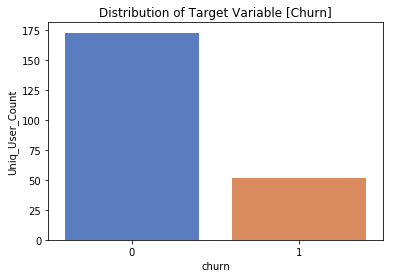

In [13]:
df_vs_class=spark.sql("select churn,count(distinct(userId)) as Uniq_User_Count from df_table group by churn").toPandas()
plt.title("Distribution of Target Variable [Churn]")
sns.barplot(x="churn", y="Uniq_User_Count", data=df_vs_class,palette="muted")
plt.show();

**lets explore variables & thier Distribution**

In [14]:
#churn By Gender Wise Uniq Users
print("churn by Gender number of uniq ");
spark.sql("select churn,gender,count(distinct(userId)) as count from df_table group by churn,gender").show();

#Churn by Level Wise Uniq Users
print("churn by Level number of uniq ")
spark.sql("select churn,level,count(distinct(userId)) as count from df_table group by churn,level").show();

#churn by Avg number of distinct sessions & Number of Users
print("churn by Avg number of distinct sessions & Number of Users");
spark.sql("select churn,avg(distinct sessionId),count(distinct(userId)) as count from df_table group by churn").show();

#churn by Avg Number of distinct Length request
print("churn by Avg Number of distinct Length request");
spark.sql("select churn,avg(distinct length),count(distinct(userId)) as count from df_table group by churn").show();

#churn by hour Wise Uniq Users
print("churn by hour number of uniq ");
spark.sql("select churn,hour,count(distinct(userId)) as count from df_table group by churn,hour").show();

#Churn by weekday Wise Uniq Users
print("churn by weekday number of uniq ");
spark.sql("select churn,weekday,count(distinct(userId)) as count from df_table group by churn,weekday").show();

#Churn by day Wise Uniq Users
print("churn by day number of uniq ");
spark.sql("select churn,day,count(distinct(userId)) as count from df_table group by churn,day").show();

#Churn by status Wise Uniq Users
print("churn by status number of uniq ");
spark.sql("select churn,status,count(distinct(userId)) as count from df_table group by churn,status").show();

#Churn by song 
print("churn by song number of uniq ");
spark.sql("select churn,count(distinct(song)) as count from df_table group by churn").show();

churn by Gender number of uniq 
+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|    1|     F|   20|
|    0|     M|   89|
|    1|     M|   32|
|    0|     F|   84|
+-----+------+-----+

churn by Level number of uniq 
+-----+-----+-----+
|churn|level|count|
+-----+-----+-----+
|    0| free|  149|
|    0| paid|  129|
|    1| paid|   36|
|    1| free|   46|
+-----+-----+-----+

churn by Avg number of distinct sessions & Number of Users
+-----+-----------------------+-----+
|churn|avg(DISTINCT sessionId)|count|
+-----+-----------------------+-----+
|    1|      559.4786324786324|   52|
|    0|     1198.2928909952607|  173|
+-----+-----------------------+-----+

churn by Avg Number of distinct Length request
+-----+--------------------+-----+
|churn|avg(DISTINCT length)|count|
+-----+--------------------+-----+
|    1|   266.5999852039152|   52|
|    0|   289.6534207610212|  173|
+-----+--------------------+-----+

churn by hour number of uniq 
+-----+----+-----+
|churn|hour|

# Feature Engineering

As we are pretty familiarized ourself with the data, we will build out the features which we found promising to train our model on. thier are many other variables which are explored above can be used for testing and improving perfomance.we can see most the variables are skewed and unbalanced towards class or target variable.

For now we will derive feature which we think mostly good predicter of target ie. churn and will use those feature to test/train our model.

**Feature 1:Playlist**

users who add more Playlist mostly not going to churn or they are going to churn? lets check?

In [15]:

spark.sql("SELECT churn,count(1)/count(DISTINCT userId)  AS Playlist FROM df_table\
                        WHERE page ='Add to Playlist' GROUP BY churn").show();

Playlist_vs=spark.sql("SELECT churn,count(1)/count(DISTINCT userId)  AS Playlist FROM df_table\
                        WHERE page ='Add to Playlist' GROUP BY churn").toPandas();

feature_Playlist=spark.sql("SELECT DISTINCT(userId),count(1)/count(DISTINCT userId) AS Playlist FROM df_table\
            WHERE page ='Add to Playlist' GROUP BY userId");


feature_Playlist.createOrReplaceTempView('feature_add_Playlist');

+-----+-----------------+
|churn|         Playlist|
+-----+-----------------+
|    1|            20.76|
|    0|33.26060606060606|
+-----+-----------------+



**Visualization plot:** feature_Playlist

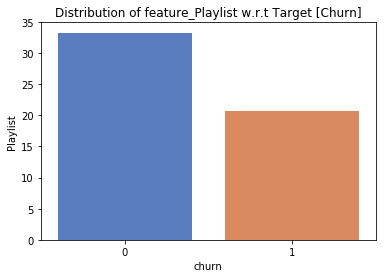

In [16]:
plt.title("Distribution of feature_Playlist w.r.t Target [Churn]");
sns.barplot(x="churn", y="Playlist", data=Playlist_vs,palette="muted");
plt.show();

Our Intution was right if he has less playlist in his app then is about to churn . we will consider this feature in our model.

**Feature 2:Usage_time based**

We can see here usage time is more for user who will not going to churn vs who is going to chur .
so will add this feature in our model.

In [17]:
spark.sql("SELECT churn,sum(length)/count(distinct userId) AS usageTime FROM df_table\
                        WHERE page = 'NextSong' GROUP BY  churn").show();

usage_time_vs=spark.sql("SELECT churn,sum(length)/count(distinct userId) AS usageTime FROM df_table\
                        WHERE page = 'NextSong' GROUP BY  churn").toPandas();

feature_usage_time=spark.sql("SELECT DISTINCT(userId),sum(nvl(length, 0)) AS usageTime FROM df_table\
                              WHERE page = 'NextSong' GROUP BY userId");

feature_usage_time.createOrReplaceTempView('feature_usage_time');


+-----+------------------+
|churn|         usageTime|
+-----+------------------+
|    1| 174014.2685513462|
|    0|276166.93746780336|
+-----+------------------+



**Visualization plot:** feature_usage_time

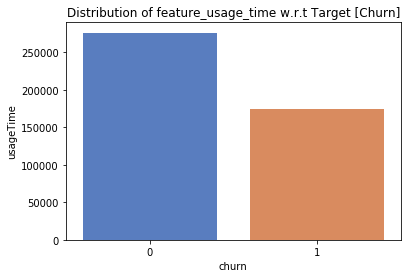

In [18]:
plt.title("Distribution of feature_usage_time w.r.t Target [Churn]");
sns.barplot(x="churn", y="usageTime", data=usage_time_vs,palette="muted");
plt.show();

**Feature 3: number of Downgrades**

this feature also looks singficant we will add this in our model.

In [19]:
spark.sql("SELECT churn,count(1)/count(DISTINCT userId)  AS Downgrade FROM df_table WHERE page ='Downgrade' GROUP BY churn").show();
Downgrade_vs=spark.sql("SELECT churn,count(1)/count(DISTINCT userId)  AS Downgrade FROM df_table WHERE page ='Downgrade' GROUP BY churn").toPandas();

feature_Downgrade=spark.sql("SELECT DISTINCT(userId),count(1)/count(DISTINCT userId) AS Downgrade FROM df_table\
                        WHERE page ='Downgrade' GROUP BY userId");

feature_Downgrade.createOrReplaceTempView('feature_Downgrade');

+-----+------------------+
|churn|         Downgrade|
+-----+------------------+
|    1| 9.628571428571428|
|    0|14.436974789915967|
+-----+------------------+



**Visualization plot:** feature_Downgrade

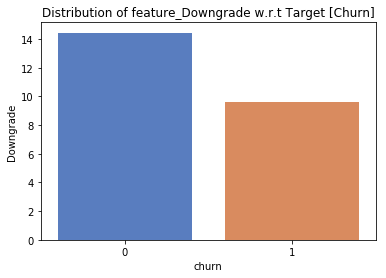

In [20]:
plt.title("Distribution of feature_Downgrade w.r.t Target [Churn]");
sns.barplot(x="churn", y="Downgrade", data=Downgrade_vs,palette="muted");
plt.show();

**Feature 4: request_help**

People who request for help are churning less compared to user who does not ask for help that makes sense so will consider this feature in our model.

In [21]:
spark.sql("SELECT churn,count(1)/count(DISTINCT userId) As help FROM df_table WHERE page ='Help' GROUP BY churn").show();
help_vs=spark.sql("SELECT churn,count(1)/count(DISTINCT userId) As help FROM df_table WHERE page ='Help' GROUP BY churn").toPandas();
feature_help=spark.sql("SELECT DISTINCT(userId),count(1)/count(DISTINCT userId) AS help FROM df_table\
                        WHERE page ='Help' GROUP BY userId");

feature_help.createOrReplaceTempView('feature_help');

+-----+-----------------+
|churn|             help|
+-----+-----------------+
|    1|5.558139534883721|
|    0|8.154362416107382|
+-----+-----------------+



**Visualization plot:** feature_help

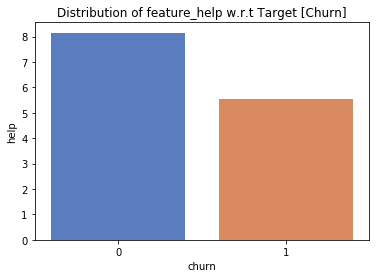

In [22]:
plt.title("Distribution of feature_help w.r.t Target [Churn]");
sns.barplot(x="churn", y="help", data=help_vs,palette="muted");
plt.show();

**Feature 5: freinds**

user who has more freinds not  going to churn as he is engaged and simiarly user who has less freinds will be churning. we will add this feature as well in our model

In [23]:
spark.sql("SELECT churn,count(1)/count(DISTINCT userId) AS Freinds FROM df_table\
            WHERE page = 'Add Friend' GROUP BY churn").show();
Freinds_vs=spark.sql("SELECT churn,count(1)/count(DISTINCT userId) AS Freinds FROM df_table\
            WHERE page = 'Add Friend' GROUP BY churn").toPandas();

feature_friends = spark.sql("SELECT DISTINCT(userId),count(1) AS Friends FROM df_table\
        WHERE page = 'Add Friend' GROUP BY userId");

feature_friends.createOrReplaceTempView('feature_friends');

+-----+------------------+
|churn|           Freinds|
+-----+------------------+
|    1|14.454545454545455|
|    0| 22.47530864197531|
+-----+------------------+



**Visualization plot:** feature_friends

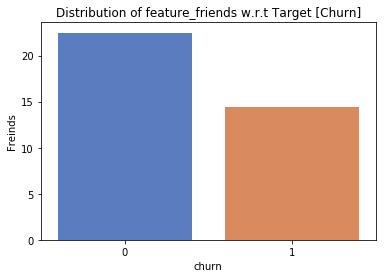

In [24]:
plt.title("Distribution of feature_friends w.r.t Target [Churn]");
sns.barplot(x="churn", y="Freinds", data=Freinds_vs,palette="muted");
plt.show();

**Feature 6: Level Paid**

paid user obviously not going to churn we will consider in our model.

In [25]:
spark.sql("SELECT churn,count(1)/count(DISTINCT userId) AS level_paid FROM df_table WHERE level = 'paid' GROUP BY churn").show();
level_paid_vs=spark.sql("SELECT churn,count(1)/count(DISTINCT userId) AS level_paid FROM df_table WHERE level = 'paid' GROUP BY churn").toPandas();

feature_level_paid = spark.sql("SELECT DISTINCT(userId),count(1)/count(DISTINCT userId) AS level_paid FROM df_table\
                    WHERE level = 'paid' GROUP BY userId");

feature_level_paid.createOrReplaceTempView('feature_level_paid');

+-----+------------------+
|churn|        level_paid|
+-----+------------------+
|    1| 902.1111111111111|
|    0|1472.5348837209303|
+-----+------------------+



**Visualization plot:** feature_level_paid

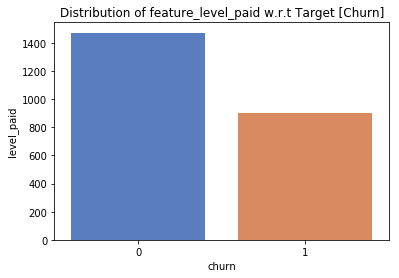

In [26]:
plt.title("Distribution of feature_level_paid w.r.t Target [Churn]");
sns.barplot(x="churn", y="level_paid", data=level_paid_vs,palette="muted");
plt.show();

**Feature 7: Level Free**

Similarly for  free users!!

In [27]:
spark.sql("SELECT churn,count(1)/count(DISTINCT userId) AS level_free FROM df_table WHERE level = 'free' GROUP BY churn").show();

level_free_vs=spark.sql("SELECT churn,count(1)/count(DISTINCT userId) AS level_free FROM df_table WHERE level = 'free' GROUP BY churn").toPandas();

feature_level_free = spark.sql("SELECT DISTINCT(userId),count(1)/count(DISTINCT userId) AS level_free FROM df_table\
                    WHERE level = 'free' GROUP BY userId");

feature_level_free.createOrReplaceTempView('feature_level_free');

+-----+------------------+
|churn|        level_free|
+-----+------------------+
|    1|269.30434782608694|
|    0| 290.8255033557047|
+-----+------------------+



**Visualization plot:** feature_level_free

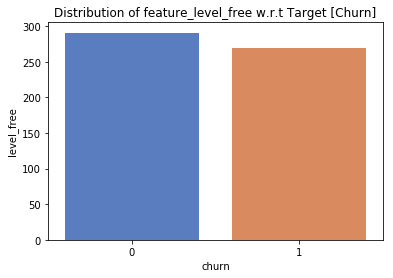

In [28]:
#distribution of Free level 
plt.title("Distribution of feature_level_free w.r.t Target [Churn]");
sns.barplot(x="churn", y="level_free", data=level_free_vs,palette="muted");
plt.show();

**Feature 8: avg sessions**
if is using most of the times then he is not goint to churn so we will add this feature in our model

In [29]:
spark.sql("SELECT churn,avg(distinct sessionId) AS avg_no_sessions FROM df_table group by churn").show();

avg_no_sessions_vs=spark.sql("SELECT churn,avg(distinct sessionId) AS avg_no_sessions FROM df_table group by churn").toPandas();

feature_avg_no_sessions = spark.sql("SELECT DISTINCT(userId),avg(distinct sessionId) AS avg_no_sessions FROM df_table group\
                            by userId");

feature_avg_no_sessions.createOrReplaceTempView('feature_avg_no_sessions');


+-----+------------------+
|churn|   avg_no_sessions|
+-----+------------------+
|    1| 559.4786324786324|
|    0|1198.2928909952607|
+-----+------------------+



**Visualization plot:** feature_avg_no_sessions

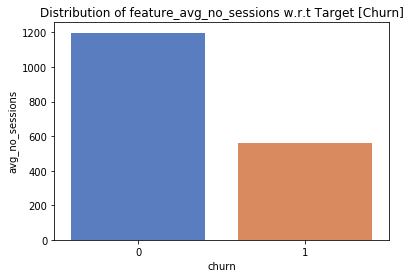

In [30]:
#distribution of avg_numberof sessions.
plt.title("Distribution of feature_avg_no_sessions w.r.t Target [Churn]");
sns.barplot(x="churn", y="avg_no_sessions", data=avg_no_sessions_vs,palette="muted");
plt.show();

**Feature 9: Gender**

Gender also important feature will consider this in our model

In [31]:
#gender
spark.sql("SELECT churn,gender,count(1)/count(DISTINCT userId) gender_cnt FROM df_table GROUP BY churn,gender").show();

gender_vs=spark.sql("SELECT churn,gender,count(1)/count(DISTINCT userId) gender_cnt FROM df_table GROUP BY churn,gender").toPandas();

feature_gender = spark.sql("SELECT DISTINCT(userId),CASE when gender='M' then 1 \
                            when gender='F' then 0 else 2 END AS gender_dummy FROM df_table");
 
feature_gender.createOrReplaceTempView('feature_gender');
spark.sql("select gender_dummy,count(DISTINCT(userId)) from feature_gender group by gender_dummy").show()

+-----+------+------------------+
|churn|gender|        gender_cnt|
+-----+------+------------------+
|    1|     F|             958.4|
|    0|     M|1099.7752808988764|
|    1|     M|             803.0|
|    0|     F|1612.0238095238096|
+-----+------+------------------+

+------------+----------------------+
|gender_dummy|count(DISTINCT userId)|
+------------+----------------------+
|           1|                   121|
|           0|                   104|
+------------+----------------------+



**Visualization plot:** feature_gender

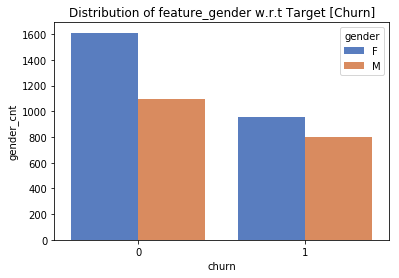

In [32]:
#distribution of gender
plt.title("Distribution of feature_gender w.r.t Target [Churn]");
sns.barplot(x="churn", y="gender_cnt", hue='gender',data=gender_vs,palette="muted");
plt.show();

#### Lets create table with all the Features we considered.....

In [33]:
#spark.sql("describe table feature_add_Playlist").show()

feature_table = spark.sql("SELECT a.userId,b.Playlist,c.usageTime,\
                            d.Downgrade,e.help,f.friends,g.level_paid,h.level_free,\
                            i.avg_no_sessions,j.gender_dummy,a.churn as label FROM df_table as a\
                            LEFT OUTER JOIN feature_add_Playlist as b\
                            ON a.userId=b.userId \
                            LEFT OUTER JOIN feature_usage_time as c\
                            ON b.userId = c.userId\
                            LEFT OUTER JOIN feature_Downgrade as d\
                            ON c.userId=d.userId\
                            LEFT OUTER JOIN feature_help as e\
                            ON d.userId=e.userId\
                            LEFT OUTER JOIN feature_friends as f\
                            ON e.userId=f.userId\
                            LEFT OUTER JOIN feature_level_paid as g\
                            ON f.userId=g.userId\
                            LEFT OUTER JOIN feature_level_free as h\
                            ON g.userId=h.userId\
                            LEFT OUTER JOIN feature_avg_no_sessions as i\
                            ON h.userId=i.userId\
                            LEFT OUTER JOIN feature_gender j\
                            on i.userId=j.userId");

feature_table.createOrReplaceTempView('feature_table')

#check distribution of class looks fine or not?
spark.sql("select label,count(distinct userId) as Class_dist from feature_table group by label").show()

+-----+----------+
|label|Class_dist|
+-----+----------+
|    1|        52|
|    0|       173|
+-----+----------+



In [34]:
#check null values
feature_table.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in feature_table.columns]).show()

+------+--------+---------+---------+-----+-------+----------+----------+---------------+------------+-----+
|userId|Playlist|usageTime|Downgrade| help|friends|level_paid|level_free|avg_no_sessions|gender_dummy|label|
+------+--------+---------+---------+-----+-------+----------+----------+---------------+------------+-----+
|     0|     464|      464|    17438|19079|  19079|     19079|     55387|          55387|       55387|    0|
+------+--------+---------+---------+-----+-------+----------+----------+---------------+------------+-----+



In [35]:
#check in case if any Null values will be present.
#impute them with zero(0) for all except gender because we it will wrong imputation so we will keep value as 2 for all null treating it differently in model.

master_feature_table = spark.sql("SELECT nvl(userId,0) as userId,nvl(Playlist,0) as Playlist,nvl(usageTime,0) as usageTime,\
        nvl(Downgrade,0) as Downgrade,nvl(help,0) as help,nvl(friends,0) as friends,nvl(level_paid,0) as level_paid,\
        nvl(level_free,0) as level_free,nvl(avg_no_sessions,0) as avg_no_sessions,nvl(gender_dummy,2) as gender,nvl(label,0) as label  FROM\
        feature_table");

#crate master_feature_table
master_feature_table.createOrReplaceTempView('master_feature_table');

**Visualization of Target(Label) w.r.t all the features**

C:\Users\vinayak\Anaconda2.7\envs\py36\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\vinayak\Anaconda2.7\envs\py36\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


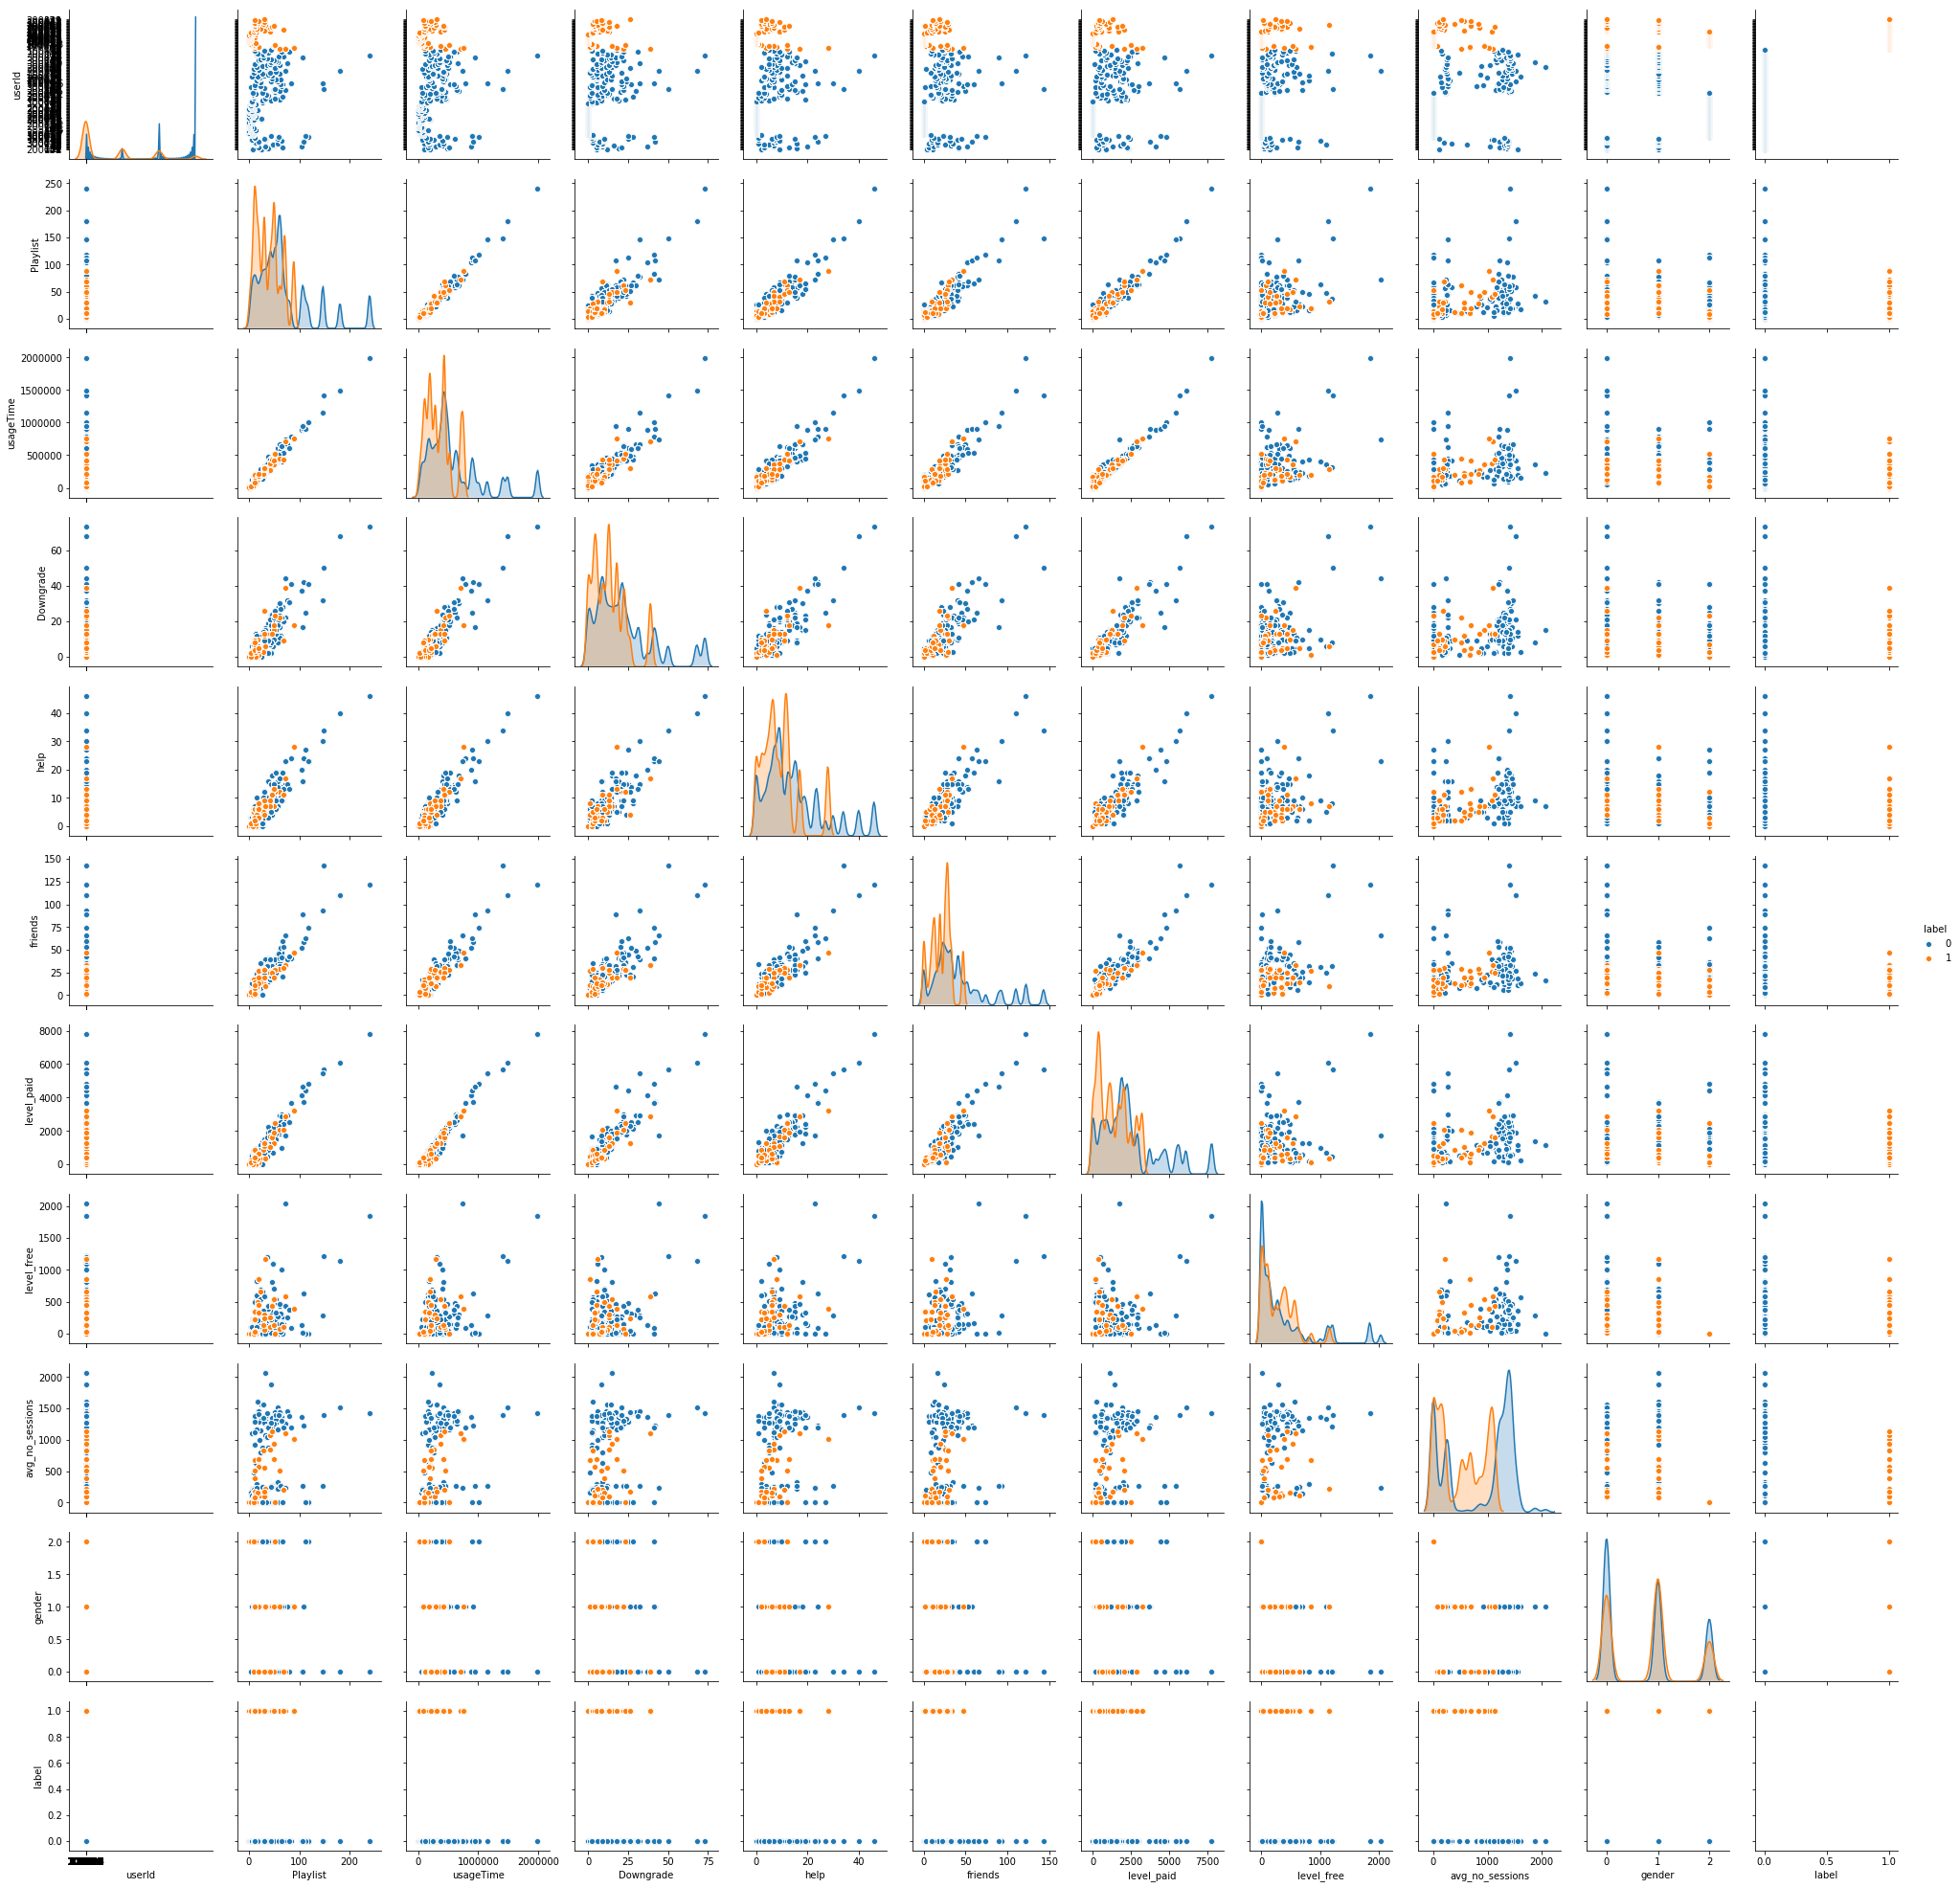

In [36]:
master_feature_vs=master_feature_table.toPandas();
sns.pairplot(master_feature_vs,hue='label');

In [37]:
#cross check and make sure no missing value present 
master_feature_table.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in master_feature_table.columns]).show()


+------+--------+---------+---------+----+-------+----------+----------+---------------+------+-----+
|userId|Playlist|usageTime|Downgrade|help|friends|level_paid|level_free|avg_no_sessions|gender|label|
+------+--------+---------+---------+----+-------+----------+----------+---------------+------+-----+
|     0|       0|        0|        0|   0|      0|         0|         0|              0|     0|    0|
+------+--------+---------+---------+----+-------+----------+----------+---------------+------+-----+



# Modeling

**Prepare data and to push to model Lets use VectorAssembler  which is transformer that combines a given list of columns into a single vector column**

Here we will implement logistic regression and RandomForest classifer and see how these model perform.Since the churned users are a fairly small subset, we using F1 score as the metric to optimize.

In [38]:
#create VectorAssembler to push data to ML models
assembler = VectorAssembler(inputCols=["Playlist","usageTime","Downgrade","help",\
                                       "friends","level_paid","level_free","avg_no_sessions","gender"],\
                            outputCol="inputFeatures")

#Lets normalize data
scaler = Normalizer(inputCol="inputFeatures", outputCol="ScaledFeatures");

In [39]:
#elasticNetParam corresponds to α and regParam corresponds to λ.
model_lr = LogisticRegression(featuresCol="ScaledFeatures", labelCol="label", maxIter=10, regParam=0.3, elasticNetParam=0.8)
model_rf = RandomForestClassifier(featuresCol="ScaledFeatures", labelCol="label")

#Create Pipeline
pipeline_lr = Pipeline(stages=[assembler, scaler, model_lr]);
pipeline_rf = Pipeline(stages=[assembler, scaler, model_rf]);

In [40]:
# spilt data for Train and test 
training, test = master_feature_table.randomSplit([0.8, 0.2]);

In [41]:
#Fit the model
model_lr_fitted = pipeline_lr.fit(training);
model_rf_fitted = pipeline_rf.fit(training);

In [42]:
#Function which will calcualte f1 scores:
def model_performance(model, test_data, metric = 'f1'):
    """ Calculate Model Scores using f1 metric 
        Input: 
            model- trained model or pipeline object
            metric- the metric used to measure performance
            data - data on which performance measurement should be done
        Output:
            score
    """
    evaluator = MulticlassClassificationEvaluator(metricName = metric)
    prediction_result = model.transform(test_data)
    # find f1 score
    score = evaluator.evaluate(prediction_result)
    #return score
    return score

In [43]:
#print both Model Testing F1-Score
print("Logistic Regression Classifier F1-Score:{}".format(model_performance(model_lr_fitted, test)));
print("Random Forest  Classifier F1-Score:{}".format(model_performance(model_rf_fitted, test)));

Logistic Regression Classifier F1-Score:0.763886400426513
Random Forest  Classifier F1-Score:0.9643577379616184


##  Summary

We have implemented two models (Logistic Regression &  Random Forest ) out of which we see Random forest clearly best model to choose with respect to f1-score as data is unbalanced.

### STEPS TO TAKE
Once we identified who will be going to churn with Prediction model we can then have to take some action to stopng them to getting churned by
* Running some promotional offers. 
* Anding finding out what is the root cause of those users not liking the Music app for ex->: may be they are not comfortable with  UI then trying to improve experiance of UI to engage users. 

## Improvement

However this is base model and model perfomance can be imporved !! .so you can please feel free try out other aproaches as we know the data is imbalanced model perfomance can be improved by applying downsampling upsampling or with cross validation .Also their are many features which  you can explore like day,week,month or song played and also can explore NLP on some features or using other models.